# Goal: Cost Minimization during Expansion

Our client is a fast-growing company selling merchandise across the US. Their team believes that as the company expands, they may benefit from moving from a single distribution warehouse (currently located in Syracuse, NY) to multiple distribution points. 

Their sales are growing at a rate of **15% a year**, so their spend with their parcel service is exploding. 

### We have been given the following information:

1. The company pays the following rates:

   * \\$5.60 / package for shipments < 500 miles
   * \\$8.70 / package for shipments < 1250 miles
   * \\$11.90 / package for shipments > 1250 US within the continental US
   * \\$18.00 / package for shipments requiring air freight
<br>

2. The company ships packages in equivalent size and weight (you may assume all packages have the same price)
<br>

3. Shipments also have surcharges – the client has very little visibility into the reasons for these so they cannot share any information with you.
<br>

4. Their current warehousing spend is **\$150K a year**.

### Our task is as follows:

*Task:* Prepare & present analysis to the client detailing what savings opportunities you see based on the data they have provided – recommendations & findings.

In [1]:
# Install relevant libraries
%pip install -q geopy
%pip install -q geopandas
%pip install -q tabulate
%pip install -q cmasher

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import geopandas as gpd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tabulate import tabulate
import cmasher as cmr
import matplotlib.patheffects as path_effects
from itertools import combinations
import matplotlib.ticker as ticker

In [3]:
# Load Excel file
file_path = 'data/Shipping_Data.xlsx'
shipping_data = pd.read_excel(file_path)

## 1. Exploratory Data Analysis: 

Conducting an exploratory data analysis on our dataset to understand the current trends in our data.

In [4]:
# Inspect first few rows of dataframe
shipping_data.head()

,Ship_Date,Delivery_Date,Shipper_State,Recipient_State,Surcharge
0,2019-10-07,2019-10-10,NY,TX,1.72
1,2019-10-11,2019-10-19,NY,CA,3.28
2,2019-10-04,2019-10-08,NY,TX,5.21
3,2019-10-10,2019-10-14,NY,TX,3.28
4,2019-10-04,2019-10-07,NY,NY,0.35


In [175]:
# How many rows and columns does our dataframe have?
shipping_data.shape

(8512, 5)

In [176]:
# How many months/years does this data span across?

# Convert date columns to datetime format
shipping_data['Ship_Date'] = pd.to_datetime(shipping_data['Ship_Date'])
shipping_data['Delivery_Date'] = pd.to_datetime(shipping_data['Delivery_Date'])

# Compute oldest and most recent shipping and delivery dates 
# Shipping Dates
min_ship_date = shipping_data['Ship_Date'].min()
max_ship_date = shipping_data['Ship_Date'].max()

# Delivery Dates
min_delivery_date = shipping_data['Delivery_Date'].min()
max_delivery_date = shipping_data['Delivery_Date'].max()

# Print results
print(f"Minimum Ship Date: {min_ship_date}")
print(f"Maximum Ship Date: {max_ship_date}")
print(f"Minimum Delivery Date: {min_delivery_date}")
print(f"Maximum Delivery Date: {max_delivery_date}")

Minimum Ship Date: 2019-10-01 00:00:00
Maximum Ship Date: 2019-10-20 00:00:00
Minimum Delivery Date: 2019-10-02 00:00:00
Maximum Delivery Date: 2019-11-01 00:00:00


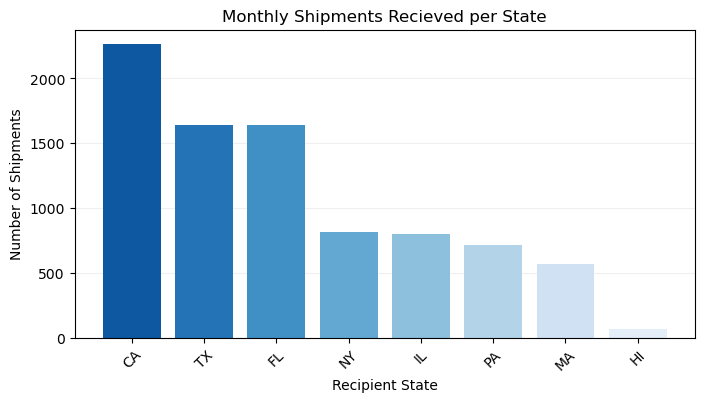

In [177]:
# Which states are recieving the most shipments?
top_shipments = shipping_data.groupby('Recipient_State').size().sort_values(ascending=False)
top_shipments

# Colormap
cmap = cmr.get_sub_cmap("Blues", 0.1, 0.95)

# Size
plt.figure(figsize=(8, 4))

# Plotting
bars = plt.bar(top_shipments.index, top_shipments.values, color=cmap((top_shipments.rank(method='first').values - 1) / len(top_shipments)))# Color coding the barchart 

# Adding labels 
plt.xlabel('Recipient State')
plt.ylabel('Number of Shipments')
plt.title('Monthly Shipments Recieved per State') # Assuming shipments in October, 2019 can be representative of monthly shipments

# Adding grid lines
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.gca().set_axisbelow(True)


# Flipping x-axis labels 
plt.xticks(rotation=45)

plt.show()

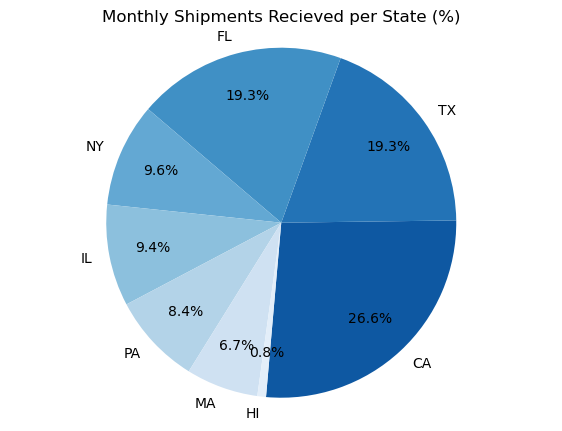

In [178]:
# Assuming shipments in October can be representative of our total monthly shipments... 
# What percent of our total monthly shipments are each state?

# Calculating the percentage of shipments for each state
total_shipments = shipping_data.shape[0]
shipments_percentage = (top_shipments / total_shipments) * 100

# Colormap
cmap = cmr.get_sub_cmap("Blues", 0.1, .95)
colors = cmap((top_shipments.rank(method='first').values - 1) / len(top_shipments))

# Size
plt.figure(figsize=(7, 5))

plt.pie(shipments_percentage, labels=top_shipments.index, autopct='%1.1f%%', pctdistance=0.75, startangle=265, colors=colors)
plt.title('Monthly Shipments Recieved per State (%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Initial Findings:

* We are working with a substantial dataset, with **8,512** shipments included.
<br>

* This data spans from **October 1st, 2019** to **November 1st, 2019**. 
    * We only have data for 1 month, or season, of the year, from 2019.
    <br>
<br>

* We observe **California, Texas, and Florida** to be the **top three shipment recipient states.** 
<br>

* Assuming shipments in October can be *representative of our total monthly shipments*:
    * Shipments to California make up roughly **27% of our total monthly shipments**. 

We should keep this information in mind as we determine our best savings opportunities; California is also one of the farthest (and thus has the most expensive shipping cost) states from New York *within the continental United States.* 

Although Hawaii is technically the farthest state from New York, and has the most expensive shipments due to air freight costs, it only makes up 0.8% of our total monthly shipments. 

## 2. Current Trends:

Digging deeper into our analysis to understand the current trends in our data. 

### A. The Distances:

Using Google Maps and our state coordinates, let's compute the distances, in miles, between each shipper and recipient state.

This will help us understand which states are farthest from our existing warehouse in Syracuse, NY, compute shipping costs based on these distances, and determine where our best savings opportunities may be.

In [179]:
# Define a dictionary of the rough coordinates for each shipping and recipient state
# I defined these coordinates using Google Maps.

state_coords = {
    
    'NY': (43.04868555688063, -76.14326881855378), # Syracuse, NY
    'CA': (36.42952717243495, -119.67356403565063),
    'TX': (31.48238547143801, -99.14820853596909),
    'FL': (27.34340267749486, -81.13025360740612),
    'IL': (40.223438568556745, -89.5906036696098),   
    'PA': (40.82948944824618, -77.5738837237264),
    'MA': (42.534953348824246, -72.09348220189612),     
    'HI': (19.82240843286814, -159.33023297095224) 
    
}

In [180]:
# Define function to compute the distances between coordinates, in miles (mi)
# Function is assuming all relevant states are found in the state_coords dictionary. Remember to update the dictionary as necessary if any new recipient/shipper states get added which are not currently in the dictionary! 

def compute_dist(shipper_state, recipient_state, state_coords):
    coord1 = state_coords[shipper_state]
    coord2 = state_coords[recipient_state]
    return geodesic(coord1, coord2).miles

# Define function to calculate the shipping cost for each shipment in the dataframe 
def calculate_shipping_cost(dist):
    if dist < 500:
        cost = 5.60
    elif dist < 1250:
        cost = 8.70
    elif dist <= 3000: # Assuming the longest distance across the continental US is 2,892 miles. 
        cost = 11.90
    else:
        cost = 18.00  
    return cost

In [181]:
shipping_data['Distance (mi)'] = shipping_data.apply(
    lambda row: compute_dist(row['Shipper_State'], row['Recipient_State'], state_coords), axis=1
).round(2)

In [182]:
# Check if new column was appropriately added
shipping_data.head()

# Observe each state and their distances 
shipping_data.groupby('Recipient_State')['Distance (mi)'].max().sort_values(ascending = False)

Recipient_State
HI    4965.42
CA    2336.07
TX    1490.28
FL    1118.31
IL     722.09
MA     208.89
PA     169.97
NY       0.00
Name: Distance (mi), dtype: float64

The farthest state we ship to is **Hawaii**, with a distance of **4965.42 miles** from our warehouse.

The farthest state we ship to **within the continental USA is California,** with a distance of **2336.07 miles** from our warehouse.

### B. The Costs:

It may also be helpful to observe the price for each package, based on:

1. Distance (mi)
<br>

2. Shipping cost ($)
<br>

3. Surcharge ($)
<br>

### Monthly Shipping Costs:

In [183]:
# Add new column with the price for each package, based on the distance, shipping cost, and surcharge.
shipping_data['Total Cost ($)'] = shipping_data.apply(
    lambda row: calculate_shipping_cost(row['Distance (mi)']) + row['Surcharge'], axis=1
)

In [184]:
# For consistency purposes, let's also rename the Surcharge column to Surcharge ($) 
shipping_data.rename({'Surcharge': 'Surcharge ($)'}, axis=1, inplace=True)

# Check if new column was appropriately added and if renaming occurred 
shipping_data

,Ship_Date,Delivery_Date,Shipper_State,Recipient_State,Surcharge ($),Distance (mi),Total Cost ($)
0,2019-10-07,2019-10-10,NY,TX,1.72,1490.28,13.62
1,2019-10-11,2019-10-19,NY,CA,3.28,2336.07,15.18
2,2019-10-04,2019-10-08,NY,TX,5.21,1490.28,17.11
3,2019-10-10,2019-10-14,NY,TX,3.28,1490.28,15.18
4,2019-10-04,2019-10-07,NY,NY,0.35,0.00,5.95
...,...,...,...,...,...,...,...
8507,2019-10-14,2019-10-16,NY,TX,6.14,1490.28,18.04
8508,2019-10-14,2019-10-23,NY,CA,0.50,2336.07,12.40
8509,2019-10-16,2019-10-16,NY,MA,0.33,208.89,5.93
8510,2019-10-14,2019-10-16,NY,IL,0.42,722.09,9.12


Continuing our analysis by computing **how much we are spending, in total, on all our shipments, monthly** as well our **current spending on shipments *per each recipient state,* monthly.**

In [185]:
shipment_spending = shipping_data['Total Cost ($)'].sum()
shipment_spending

115290.22

In [186]:
# Computing total spending on monthly shipments for each recipient state 
spending_per_state = shipping_data.groupby('Recipient_State')['Total Cost ($)'].sum().sort_values(ascending=False)
spending_per_state

Recipient_State
CA    35771.32
TX    26322.27
FL    21162.15
IL    10308.07
NY     8200.37
PA     6574.69
MA     4908.80
HI     2042.55
Name: Total Cost ($), dtype: float64

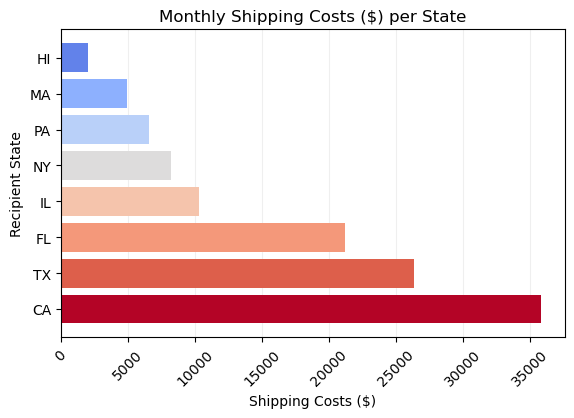

In [187]:
# Plot costs on a bar plot

# Colormap
cmap = plt.get_cmap("coolwarm")
colors = cmap((spending_per_state.rank(ascending=True).values) / len(spending_per_state))

plt.figure(figsize=(6.5, 4))
bars = plt.barh(spending_per_state.index, spending_per_state.values, color=colors)

# Adding labels 
plt.xlabel('Shipping Costs ($)')
plt.ylabel('Recipient State')
plt.title('Monthly Shipping Costs ($) per State') # Assuming shipments in October, 2019 can be representative of monthly shipments

# Adding grid lines
plt.grid(axis='x', linestyle='-', alpha=0.2)
plt.gca().set_axisbelow(True)

# Flipping x-axis labels 
plt.xticks(rotation=45)

plt.show()

### State with the Most Monthly Shipping Costs:

In [188]:
highest_shipping_state_mn = spending_per_state.idxmax()
highest_shipping_value_mn = spending_per_state.max()

print(f"The state with the most monthly shipping costs is {highest_shipping_state_mn} with a value of ${highest_shipping_value_mn:,.2f} a year.")

The state with the most monthly shipping costs is CA with a value of $35,771.32 a year.


### Annual Shipping Costs:

Continuing our analysis by computing **how much we are spending, in total, on all our shipments, annually** as well our **current spending on shipments *per each recipient state,* annually.**

In [189]:
# Computing total spending on annual shipments for each recipient state 
spending_per_state_ann = (shipping_data.groupby('Recipient_State')['Total Cost ($)'].sum()*12).sort_values(ascending=False)
spending_per_state_ann

Recipient_State
CA    429255.84
TX    315867.24
FL    253945.80
IL    123696.84
NY     98404.44
PA     78896.28
MA     58905.60
HI     24510.60
Name: Total Cost ($), dtype: float64

In [190]:
# What is our total shipment spend, annually? 
annual_shipment_spend = spending_per_state_ann.sum()

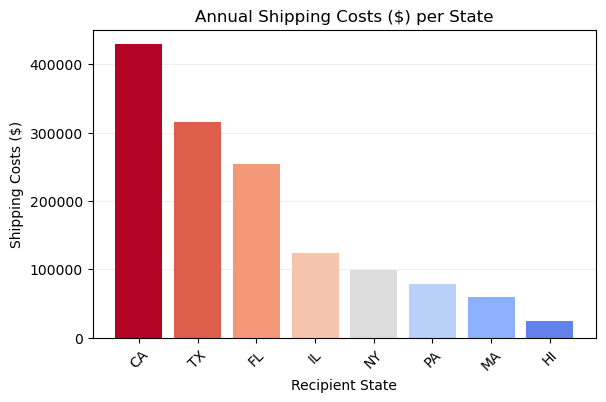

In [191]:
# Let's plot the ANNUAL costs on a bar plot.

# Size
plt.figure(figsize=(6.5, 4))

# Plotting
bars = plt.bar(spending_per_state_ann.index, spending_per_state_ann.values, color=colors) # Color coding the barchart 

# Adding labels 
plt.xlabel('Recipient State')
plt.ylabel('Shipping Costs ($)')
plt.title('Annual Shipping Costs ($) per State') # Assuming shipments in October, 2019 can be representative of monthly shipments

# Adding grid lines
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.gca().set_axisbelow(True)

# Flipping x-axis labels 
plt.xticks(rotation=45)

plt.show()

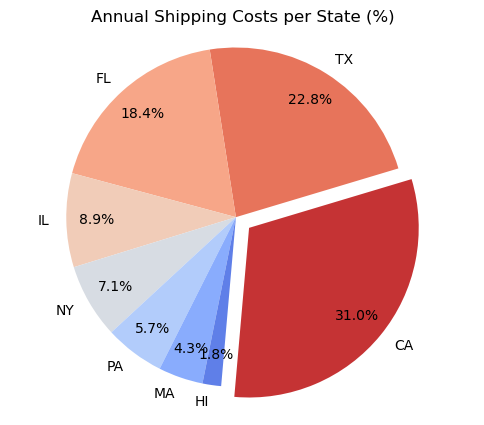

In [192]:
# Calculating the percentage cost of shipments for each state out of total ANNUAL shipping costs 
shipments_costs_percentage_ann = (spending_per_state_ann / annual_shipment_spend) * 100

# Plotting piechart of percentages
# Size
plt.figure(figsize=(6, 5))

# Colormap
cmap = cmr.get_sub_cmap('coolwarm', 0, 0.95)
colors = cmap((shipments_costs_percentage_ann.rank(ascending=True).values) / len(shipments_costs_percentage_ann))

# Highlight state with highest costs of total shipments 
explode = [0.1 if i == 0 else 0 for i in range(len(shipments_costs_percentage_ann))]

plt.pie(shipments_costs_percentage_ann, labels=shipments_costs_percentage_ann.index, autopct='%1.1f%%', pctdistance=0.82, startangle=265, colors=colors, explode=explode)

plt.title('Annual Shipping Costs per State (%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### State with the Most Annual Shipping Costs:

In [193]:
# Finding the state with the highest value in spending_per_state
highest_shipping_state = spending_per_state_ann.idxmax()
highest_shipping_value = spending_per_state_ann.max()

# Printing the state and value
print(f"The state with the most annual shipping costs is {highest_shipping_state} with a value of ${highest_shipping_value:,.2f} a year.")

The state with the most annual shipping costs is CA with a value of $429,255.84 a year.


In [194]:
# Define our current annual warehousing spend, which we know from above to be $150K
# Assume 150k covers all initial warehouse setup, building and maintenance, for current and new warehouses 

annual_warehouse_cost = 150000
print(f"Annual Warehouse Cost: ${annual_warehouse_cost:,}")

Annual Warehouse Cost: $150,000


In [195]:
# What is our total annual spend (including our shipment costs and warehousing spend)?
curr_total_spending = annual_shipment_spend + annual_warehouse_cost
print(f"Annual TOTAL Spending: ${curr_total_spending:,.2f}")

Annual TOTAL Spending: $1,533,482.64


In [196]:
# What is our total shipment spend, annually? 
annual_shipment_spend = spending_per_state_ann.sum()
print(f"Annual Shipment Spend: ${annual_shipment_spend:,.2f}")

Annual Shipment Spend: $1,383,482.64


In [197]:
# What proportion of our current total annual spend are our monthly shipments? 
print(f"Percent of Total Annual Spending representing ONLY Shipments: {(annual_shipment_spend / curr_total_spending)*100:.2f}%") 

Percent of Total Annual Spending representing ONLY Shipments: 90.22%


## 3. Cost-Breakdown Analysis of Current Trends:

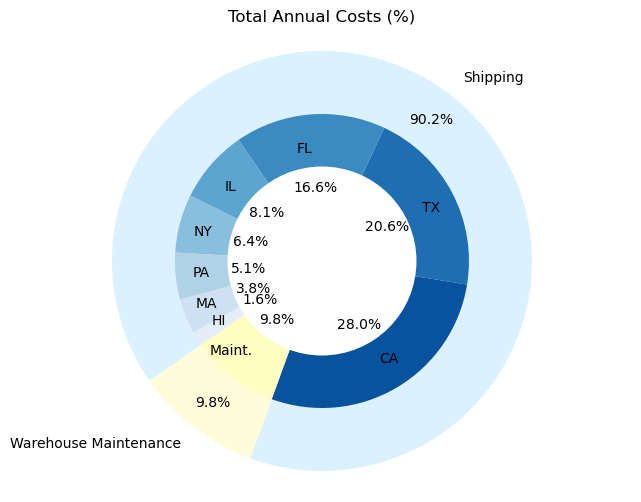

In [198]:
# Donut chart of cost breakdown analysis 

# Include the warehouse cost in the data series
costs = pd.Series()
costs['Shipping'] = annual_shipment_spend
costs['Warehouse Maintenance'] = annual_warehouse_cost

# Overarching Cost Breakdown
costs_percentage_ann = (costs / curr_total_spending) * 100

# Include the warehouse cost in the data series
costs_inner = (shipping_data.groupby('Recipient_State')['Total Cost ($)'].sum()*12).sort_values(ascending=False)
costs_inner['Maint.'] = annual_warehouse_cost

# Calculate the percentage cost of shipments for each state out of total annual shipping costs
percentages_subgroup = (costs_inner / curr_total_spending) * 100

# Generate a list of colors 
colors = ['#dcf1ff', '#fffdd9']
cmap = cmr.get_sub_cmap("Blues", 0.1, 0.87)
colors_subgroup = [cmap(i / (len(percentages_subgroup) - 2)) for i in range(len(percentages_subgroup) - 2, -1, -1)] + ['#fffdc0']

# Plotting donut chart of percentages
plt.figure(figsize=(8, 6))

outside_donut = plt.pie(costs_percentage_ann, labels=costs_percentage_ann.index, colors=colors, pctdistance=0.85, startangle=250, frame=True, autopct='%1.1f%%')
inside_donut = plt.pie(percentages_subgroup, labels=percentages_subgroup.index, colors=colors_subgroup, radius=0.7, startangle=250, labeldistance=0.77, autopct='%1.1f%%', pctdistance=0.5)


# Adding center circle for the donut chart
centre_circle = plt.Circle((0,0),0.45,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Total Annual Costs (%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### If we *assume that our sales in the month of October are representative of our monthly spending*, and that shipping costs remain the same each month for each state, then we come to the following conclusions: 

* Our **current grand total of annual warehouse costs - *shipment and maintenance costs combined* - is \\$1,533,482.64**
<br>

* Shipping costs make up about **90%** of our total annual warehouse costs. 
    * We are spending a total of **\\$1,383,482.64 on shipments each year**.
    * The state with the most shipping costs is California, with **a whopping \\$429,255.84 spent on shipments to California, annually**. 
    <br>
<br>

* **Shipments to CA** from our warehouse location in Syracuse, NY make up approximately **31% of our annual shipping costs, and 28% of our *total* annual costs.**
    * This is significant, compared to what percent shipments to other states make up of our total shipping costs.
    * Shipments to Texas, which is the second top shipment recipient state, make up roughly 21% of our total annual costs, and shipments to Hawaii, although most expensive due to the air freight cost, make up less than 2% of our total annual costs.

## 4. Projected Future Sales:

**Let's estimate what our costs will be over the next 5 years, given our 15% YoY growth rate.**

In [199]:
# Estimate future annual shipping totals using our 15% YoY growth rate over the next 5 years

years = 6
rate = 0.15

# Compute future annual shipping totals over the next 5 years, and add on annual warehouse spend of $150K
future_spending = [annual_shipment_spend * ((1 + rate) ** year) + annual_warehouse_cost for year in range(1, years)]

# Display results
future_spending_df = pd.DataFrame({
    'Year': [year for year in range(2019, 2025)],
    'Projected Total Spending in Millions ($)': [curr_total_spending] + future_spending
})

future_spending_df['Projected Total Spending in Millions ($)']
future_spending_df

,Year,Projected Total Spending in Millions ($)
0,2019,1.533483e+06
1,2020,1.741005e+06
2,2021,1.979656e+06
3,2022,2.254104e+06
4,2023,2.569720e+06
5,2024,2.932678e+06


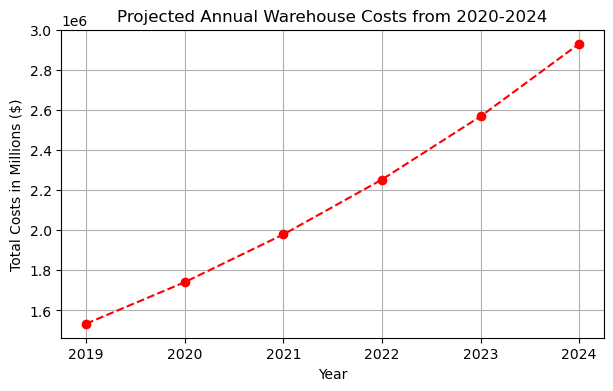

In [200]:
# Illustrate this over the next 5 years using a data visual 

plt.figure(figsize=(7, 4))
plt.plot(future_spending_df['Year'], future_spending_df['Projected Total Spending in Millions ($)'], marker='o', linestyle='--', color = 'red')
plt.title('Projected Annual Warehouse Costs from 2020-2024')
plt.xlabel('Year')
plt.ylabel('Total Costs in Millions ($)')
plt.grid(True) # adds grid lines 

# Remove the index axis
plt.xticks(future_spending_df['Year'])

plt.show()

With our 15% YoY growth rate, **costs are almost doubling** over the next 5 years with just our one warehouse.

## 5. Determining our Best Savings Opportunities:

It may be helpful to take a look at a map of where our shipments are being exported from and imported into to better understand our data points, the distances between them, and how we might strategize to save on costs.

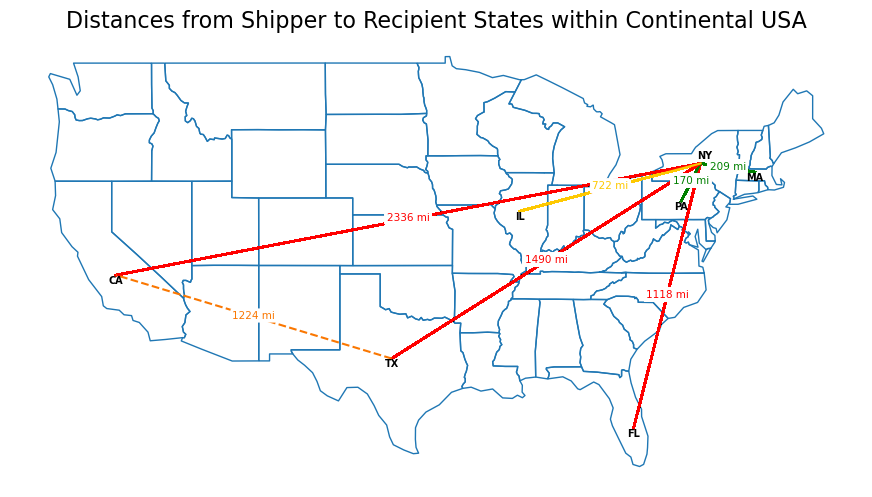

In [201]:
shipping_data['Shipper_Coordinates'] = shipping_data['Shipper_State'].map(state_coords)
shipping_data['Recipient_Coordinates'] = shipping_data['Recipient_State'].map(state_coords)

# Filter out rows where either the shipper or recipient state is Hawaii
shipping_df = shipping_data[
    (shipping_data['Shipper_State'] != 'HI') & 
    (shipping_data['Recipient_State'] != 'HI')
]

# Load the US states shapefile from the local directory
us_states = gpd.read_file('states/states.shp')

# Filter states to show only the continental USA
us_states = us_states[(us_states['admin'] == 'United States of America') & 
                      (us_states['name'] != 'Hawaii') & 
                      (us_states['name'] != 'Alaska')]

# Function to color-code distance
def get_color(distance):
    if distance < 500:
        return 'green'
    elif 500 <= distance < 1000:
        return '#FEC901'
    else:
        return 'red'

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(11, 9.5))

# Plot US states
us_states.boundary.plot(ax=ax, linewidth=1)

# Plot lines between shipper and recipient states and label distances
for idx, row in shipping_df.iterrows():
    shipper_coord = row['Shipper_Coordinates']
    recipient_coord = row['Recipient_Coordinates']
    distance = geodesic(shipper_coord, recipient_coord).miles
    if distance > 0:
        color = get_color(distance)
        ax.plot([shipper_coord[1], recipient_coord[1]], [shipper_coord[0], recipient_coord[0]], color=color, linestyle='-')
        mid_x = (shipper_coord[1] + recipient_coord[1]) / 2
        mid_y = (shipper_coord[0] + recipient_coord[0]) / 2
        ax.text(mid_x, mid_y-0.1, f'{distance:.0f} mi', fontsize=7.5, ha='center', color=color, bbox=dict(facecolor='white', alpha=1, boxstyle="round,pad=0.2", edgecolor='none'))

# Create a dictionary for state acronyms, only for relevant states. Update as necessary 
state_acronyms = { 
    'California': 'CA', 
    'Florida': 'FL', 
    'Illinois': 'IL',
    'Massachusetts': 'MA',
    'New York': 'NY',
    'Pennsylvania': 'PA', 
    'Texas': 'TX'  
}    
    
# Add state labels acronyms
for state, coords in state_coords.items():
    if state in state_acronyms.values():
        if state == 'NY':
            ax.text(coords[1] + 0.3, coords[0] + 0.3, state, ha='center', fontsize=7, color='black', weight='bold')
        else:
            ax.text(coords[1], coords[0] - 0.51, state, ha='center', fontsize=7, color='black', weight='bold')

# Plot dashed line from Texas to California, to show the reduced distance of TX-CA with another warehouse in CA compared to TX-NY 
tx_coords = state_coords['TX']
ca_coords = state_coords['CA']
distance = geodesic(tx_coords, ca_coords).miles
ax.plot([tx_coords[1], ca_coords[1]], [tx_coords[0], ca_coords[0]], color='#FA7701', linestyle='--')
mid_x = (tx_coords[1] + ca_coords[1]) / 2
mid_y = (tx_coords[0] + ca_coords[0]) / 2
ax.text(mid_x, mid_y - 0.1, f'{distance:.0f} mi', fontsize=7.5, ha='center', color='#FA7701', bbox=dict(facecolor='white', alpha=1, boxstyle="round,pad=0.2", edgecolor='none'))

# Remove x and y axes labels
ax.set_axis_off()        
        
# Plot final map
plt.title('Distances from Shipper to Recipient States within Continental USA', fontsize = 16)
plt.show()

## Findings:

From this map, we observe our farthest distances from New York for shipments are to California, Texas, and Florida. 

**As seen from above, shipments to California are costing us the most money**, as shipment prices are mainly based on distance--so **an additional distribution point in CA** appears to be a potential optimal savings opportunity for us. 

Furthermore- TX and CA are closer geographically than TX and NY. This difference in distance is significant; since the distance between TX and CA is <1250 mi, another warehouse in CA would **bring down shipping costs** per package to TX from the current rate of **\\$11.90/package when shipping from NY** to **\\$8.70/per package when shipping from CA.** 

Given Texas is our top second shipment location, another warehouse in California *also* **reduce shipping costs to TX.**

To validate our hypothesis, let's compare what our savings would have been in 2019 with a hypothetical second distribution point given each recipient state. 

### To calculate what our new total spending cost for 2019 would've been with a second warehouse, we would:

* Calculate all shipping costs from our existing warehouse in NY.
<br>

* Calculate all shipping costs from our hypothetical new second warehouse location.
<br>

* Choose the minimal shipping cost for each of our shipments.
<br>

* Add on our annual maintenance cost of \\$150K for each warehouse.

*Assuming that an additional warehouse would also cost \\$150k per year,* let's determine the best location to open additional distribution points/warehouses in order to minimize future shipping costs. 

## 6. Projected Future Savings:

In [202]:
# This code block can be re-run any time we want to determine if a warehouse in another location will minimize our future costs; we just need to add the new state to our recipient coords dictionary!

# Initialize the current warehouse details
curr_warehouse_location = 'NY'
curr_warehouse_coord = state_coords[curr_warehouse_location]

# Function to compute new total costs with a new warehouse
def compute_costs_with_new_warehouse(new_warehouse_coord):
    def compute_cost(row):
        recipient_coord = row['Recipient_Coordinates']
        
        # Compute distances
        distance_curr = geodesic(curr_warehouse_coord, recipient_coord).miles
        distance_new = geodesic(new_warehouse_coord, recipient_coord).miles
        
        # Choose the warehouse that has the minimum distance to minimize cost
        distance = min(distance_curr, distance_new)
        
        # Return the updated cost of shipping for that package
        return calculate_shipping_cost(distance) + row['Surcharge ($)']
    
    shipping_data['Updated Total Cost ($)'] = shipping_data.apply(compute_cost, axis=1)
    new_annual_shipment_spend = shipping_data['Updated Total Cost ($)'].sum() * 12
    new_total_spending = new_annual_shipment_spend + 2 * annual_warehouse_cost
    return new_total_spending, new_annual_shipment_spend

# List to store results
results = []

# Iterate over each possible new warehouse location-- excluding NY
for new_warehouse_location, new_warehouse_coord in state_coords.items():
    if new_warehouse_location == 'NY':
        continue
    new_total_spending, new_annual_shipment_spend = compute_costs_with_new_warehouse(new_warehouse_coord)
    
    # Calculate savings
    savings = curr_total_spending - new_total_spending
    p_savings = (savings / curr_total_spending) * 100
    shipment_cost_savings = annual_shipment_spend - new_annual_shipment_spend
    p_shipment_cost_savings = (shipment_cost_savings / annual_shipment_spend) * 100
    
    # Append results
    results.append({
        'New Warehouse Location': new_warehouse_location,
        'New Total Cost ($)': new_total_spending,
        'Total Savings ($)': savings,
        'Percent Total Savings (%)': p_savings.round(2),
        'New Shipping Costs ($)': new_annual_shipment_spend,
        'Savings on Shipment Costs ($)': shipment_cost_savings,
        'Percent Savings on Shipment Costs (%)': p_shipment_cost_savings
    })

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Sort DataFrame by Total Savings in descending order
results_df = results_df.sort_values(by='Total Savings ($)', ascending=False)
results_df

,New Warehouse Location,New Total Cost ($),Total Savings ($),Percent Total Savings (%),New Shipping Costs ($),Savings on Shipment Costs ($),Percent Savings on Shipment Costs (%)
0,CA,1444332.24,89150.4,5.81,1144332.24,2.391504e+05,1.728611e+01
1,TX,1472485.44,60997.2,3.98,1172485.44,2.109972e+05,1.525116e+01
2,FL,1559460.24,-25977.6,-1.69,1259460.24,1.240224e+05,8.964507e+00
3,IL,1590745.44,-57262.8,-3.73,1290745.44,9.273720e+04,6.703170e+00
6,HI,1673364.24,-139881.6,-9.12,1373364.24,1.011840e+04,7.313717e-01
4,PA,1683482.64,-150000.0,-9.78,1383482.64,-2.328306e-10,-1.682931e-14
5,MA,1683482.64,-150000.0,-9.78,1383482.64,-2.328306e-10,-1.682931e-14


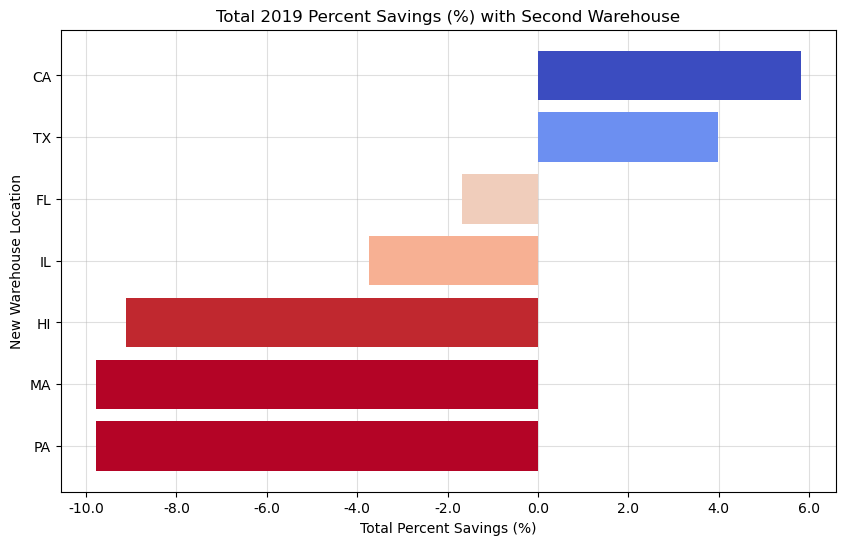

In [203]:
# Let's plot these savings for each state on a bar chart.
# Plotting Total Savings for each state

# Set Size
plt.figure(figsize=(10, 6))

# Sorting the df
results_df = results_df.sort_values(by='Percent Total Savings (%)', ascending=True)

# Colormap
cmap = plt.get_cmap("coolwarm").reversed()
norm = mcolors.TwoSlopeNorm(vmin=results_df['Percent Total Savings (%)'].min(), 
                            vcenter=0, 
                            vmax=results_df['Percent Total Savings (%)'].max())

# Colors based on normalized values
colors = cmap(norm(results_df['Percent Total Savings (%)']))

# Plotting Bar
bars = plt.barh(results_df['New Warehouse Location'], results_df['Percent Total Savings (%)'], color=colors)

# Adding grid lines
plt.grid(axis='x', linestyle='-', alpha=0.4)
plt.grid(axis='y', linestyle='-', alpha=0.4)

plt.gca().set_axisbelow(True)

# Formatting x-axis to display decimals
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Labels 
plt.ylabel('New Warehouse Location')
plt.xlabel('Total Percent Savings (%)')
plt.title('Total 2019 Percent Savings (%) with Second Warehouse')

plt.show()

### We can observe our hypothesis is correct: another warehouse in CA would allow us to optimize our savings and reduce costs most by 5.8%. 

The next optimal location for a warehouse would have been TX, which would've reduced costs by almost 4%. 

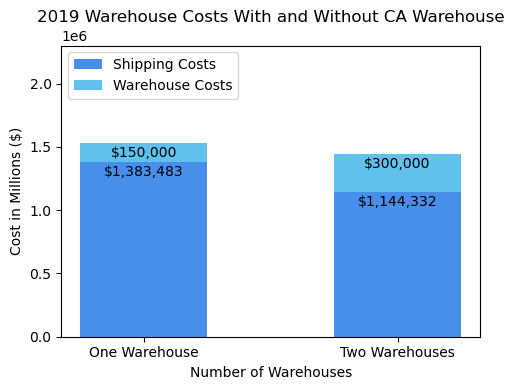

In [204]:
# Sorting the df
results_df = results_df.sort_values(by='Percent Total Savings (%)', ascending=False)

CA_costs = [results_df.iloc[0]['New Total Cost ($)'],
             results_df.iloc[0]['Total Savings ($)'], 
             results_df.iloc[0]['Percent Total Savings (%)'], 
             results_df.iloc[0]['Savings on Shipment Costs ($)'],
             results_df.iloc[0]['New Shipping Costs ($)'],
             results_df.iloc[0]['Percent Savings on Shipment Costs (%)']
            ]

# Define the costs
warehouse_costs_one = annual_warehouse_cost
shipping_costs_one = annual_shipment_spend

warehouse_costs_two = annual_warehouse_cost*2
shipping_costs_two = CA_costs[4]

# Create labels and positions
labels = ['One Warehouse', 'Two Warehouses']
x = range(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))  
bar_width = 0.5

# Plot the stacked bars
rects1 = ax.bar(x, [shipping_costs_one, shipping_costs_two], bar_width, label='Shipping Costs', color='#478fea')
rects2 = ax.bar(x, [warehouse_costs_one, warehouse_costs_two], bar_width, bottom=[shipping_costs_one, shipping_costs_two], label='Warehouse Costs', color='#60c1ec')

# Add labels
ax.set_xlabel('Number of Warehouses')
ax.set_ylabel('Cost in Millions ($)')

# Set y-axis limit
ax.set_ylim(0, max(CA_costs[0], curr_total_spending) * 1.5)

# Add title and legend
ax.set_title('2019 Warehouse Costs With and Without CA Warehouse')
ax.set_xticks([i for i in x])
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

# Display the values just below the top of the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'${height:,.0f}',
                xy=(rect.get_x() + rect.get_width() / 2, height + rect.get_y()),  # Right at the top of the bar
                xytext=(0, -12.5),  # Offset to place the text just below the top
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

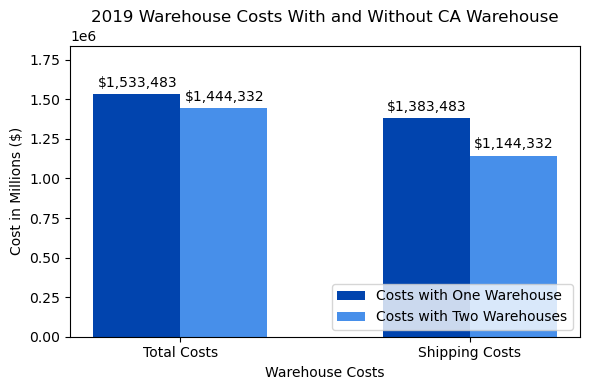

Former Total Cost with 1 Warehouse: $1,533,482.64
New Total Cost with 2 Warehouses: $1444332.24
Total Savings: $89,150.40
Percent Total Savings: 5.81%
Savings on Shipment Costs: $239,150.40
New Percent of Total Annual Spending representing ONY Shipments: 79.23%
Percent Savings on Shipment Costs: 17.29%


In [205]:
# Plotting the bar chart
labels = ['Total Costs', 'Shipping Costs']
former_costs = [curr_total_spending, annual_shipment_spend]

# Sorting the df
results_df = results_df.sort_values(by='Percent Total Savings (%)', ascending=False)

CA_costs = [results_df.iloc[0]['New Total Cost ($)'],
             results_df.iloc[0]['Total Savings ($)'], 
             results_df.iloc[0]['Percent Total Savings (%)'], 
             results_df.iloc[0]['Savings on Shipment Costs ($)'],
             results_df.iloc[0]['New Shipping Costs ($)'],
             results_df.iloc[0]['Percent Savings on Shipment Costs (%)']
            ]

x = range(len(labels))

fig, ax = plt.subplots(figsize=(6, 4))  
bar_width = 0.30

# Plot the bars
rects1 = ax.bar(x, former_costs, bar_width, label='Costs with One Warehouse', color='#0144ae')
rects2 = ax.bar([i + bar_width for i in x], [CA_costs[0], CA_costs[4]], bar_width, label='Costs with Two Warehouses', color='#478fea')

# Add labels
ax.set_xlabel('Warehouse Costs')
ax.set_ylabel('Cost in Millions ($)')

# Set y-axis limit
ax.set_ylim(0, max(former_costs) * 1.2)  # Adjust the multiplier to set the range larger to make the plot clearer

# Add title and legend
ax.set_title('2019 Warehouse Costs With and Without CA Warehouse')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

# Display the values on top of the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'${height:,.0f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0.5, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Former Total Cost with 1 Warehouse: ${curr_total_spending:,}")

print(f"New Total Cost with 2 Warehouses: ${CA_costs[0]}")

print(f"Total Savings: ${CA_costs[1]:,.2f}")

print(f"Percent Total Savings: {CA_costs[2]:,.2f}%")

# How much are we saving on shipment costs?
print(f"Savings on Shipment Costs: ${CA_costs[3]:,.2f}")

# What proportion of our new current total annual spend are now our monthly shipments? 
print(f"New Percent of Total Annual Spending representing ONY Shipments: {(CA_costs[4] / CA_costs[0])*100:.2f}%")

print(f"Percent Savings on Shipment Costs: {CA_costs[5]:,.2f}%")

### With a new warehouse location in CA, our total spending for this year (2019) alone would have been down by **$89,150.40**: 
### That's about **5.81% in savings**.
<br>

* We'd have saved **$239,150.40 on shipments.**
    * We'd have gone from from *90% of our total annual spend* being due to shipment costs to *just 79% of our total annual spend* being due to shipment costs. 
    * Our **shipping costs** would've been **down 17.29%**.

From a first glance, it seems like **a second warehouse in CA is a prime savings opportunity for us.** 

We also know the next optimal location for a warehouse would have been TX, which would've reduced costs by almost 4%.

### Let's see if opening a third warehouse, TX, alongside one in CA, would allow us to optimize our savings even more.

The code below will run through all possible pairs of warehouses that could be opened in any of our recipient states to see which pair may minimize costs the most.

In [206]:
# This code block can be re-run any time we want to determine if a warehouse pair in another location will minimize our future costs.

# Initialize the current warehouse details
curr_warehouse_location = 'NY'
curr_warehouse_coord = state_coords[curr_warehouse_location]

# Function to compute new total costs with two new warehouses
def compute_costs_with_two_warehouses(new_warehouse_coord1, new_warehouse_coord2):
    def compute_cost(row):
        recipient_coord = row['Recipient_Coordinates']
        
        # Compute distances
        distance_curr = geodesic(curr_warehouse_coord, recipient_coord).miles
        distance_new1 = geodesic(new_warehouse_coord1, recipient_coord).miles
        distance_new2 = geodesic(new_warehouse_coord2, recipient_coord).miles
        
        # Choose the warehouse that has the minimum distance to minimize cost
        distance = min(distance_curr, distance_new1, distance_new2)
        
        # Return the updated cost of shipping for that package
        return calculate_shipping_cost(distance) + row['Surcharge ($)']
    
    shipping_data['Updated Total Cost ($)'] = shipping_data.apply(compute_cost, axis=1)
    new_annual_shipment_spend = shipping_data['Updated Total Cost ($)'].sum() * 12
    new_total_spending = new_annual_shipment_spend + 3 * annual_warehouse_cost  # Including the current warehouse
    return new_total_spending, new_annual_shipment_spend

# List to store results
results_2 = []

# Iterate over each possible pair of new warehouse locations, excluding NY
possible_locations = [loc for loc in state_coords.keys() if loc != 'NY']
for loc1, loc2 in combinations(possible_locations, 2):
    new_warehouse_coord1 = state_coords[loc1]
    new_warehouse_coord2 = state_coords[loc2]
    
    new_total_spending, new_annual_shipment_spend = compute_costs_with_two_warehouses(new_warehouse_coord1, new_warehouse_coord2)
    
    # Calculate savings
    savings = curr_total_spending - new_total_spending
    p_savings = (savings / curr_total_spending) * 100
    shipment_cost_savings = annual_shipment_spend - new_annual_shipment_spend
    p_shipment_cost_savings = (shipment_cost_savings / annual_shipment_spend) * 100
    
    # Append results
    results_2.append({
        'New Warehouse Location 1': loc1,
        'New Warehouse Location 2': loc2,
        'New Total Cost ($)': new_total_spending,
        'Total Savings ($)': savings,
        'Percent Total Savings (%)': p_savings.round(2),
        'New Shipping Costs ($)': new_annual_shipment_spend, 
        'Savings on Shipment Costs ($)': shipment_cost_savings,
        'Percent Savings on Shipment Costs (%)': p_shipment_cost_savings
    })

# Create DataFrame from results
results_df_2 = pd.DataFrame(results_2)

# Sort DataFrame by Total Savings in descending order
results_df_2 = results_df_2.sort_values(by='Total Savings ($)', ascending=False)
results_df_2

,New Warehouse Location 1,New Warehouse Location 2,New Total Cost ($),Total Savings ($),Percent Total Savings (%),New Shipping Costs ($),Savings on Shipment Costs ($),Percent Savings on Shipment Costs (%)
0,CA,TX,1533287.04,195.6,0.01,1083287.04,3.001956e+05,2.169854e+01
1,CA,FL,1533324.24,158.4,0.01,1083324.24,3.001584e+05,2.169586e+01
6,TX,FL,1561477.44,-27994.8,-1.83,1111477.44,2.720052e+05,1.966090e+01
2,CA,IL,1564609.44,-31126.8,-2.03,1114609.44,2.688732e+05,1.943452e+01
5,CA,HI,1589191.44,-55708.8,-3.63,1139191.44,2.442912e+05,1.765770e+01
7,TX,IL,1592762.64,-59280.0,-3.87,1142762.64,2.407200e+05,1.739957e+01
3,CA,PA,1594332.24,-60849.6,-3.97,1144332.24,2.391504e+05,1.728611e+01
4,CA,MA,1594332.24,-60849.6,-3.97,1144332.24,2.391504e+05,1.728611e+01
10,TX,HI,1612367.04,-78884.4,-5.14,1162367.04,2.211156e+05,1.598254e+01
9,TX,MA,1622485.44,-89002.8,-5.80,1172485.44,2.109972e+05,1.525116e+01


In [207]:
results_df_2[['New Warehouse Location 1', 'New Warehouse Location 2', 'Total Savings ($)', 'Percent Total Savings (%)']].head()

,New Warehouse Location 1,New Warehouse Location 2,Total Savings ($),Percent Total Savings (%)
0,CA,TX,195.6,0.01
1,CA,FL,158.4,0.01
6,TX,FL,-27994.8,-1.83
2,CA,IL,-31126.8,-2.03
5,CA,HI,-55708.8,-3.63


### While an additional warehouse in both CA and TX would result in *some* savings, they are insignificant compared to those of opening a singular additional distribution point in CA.

## 7. Long-term Benefits: 

### Let's confirm the long-term benefits of a commitment to opening a new second warehouse in CA, and observe **how much we would *really* save, annually, over the next 5 years, with a second warehouse.**

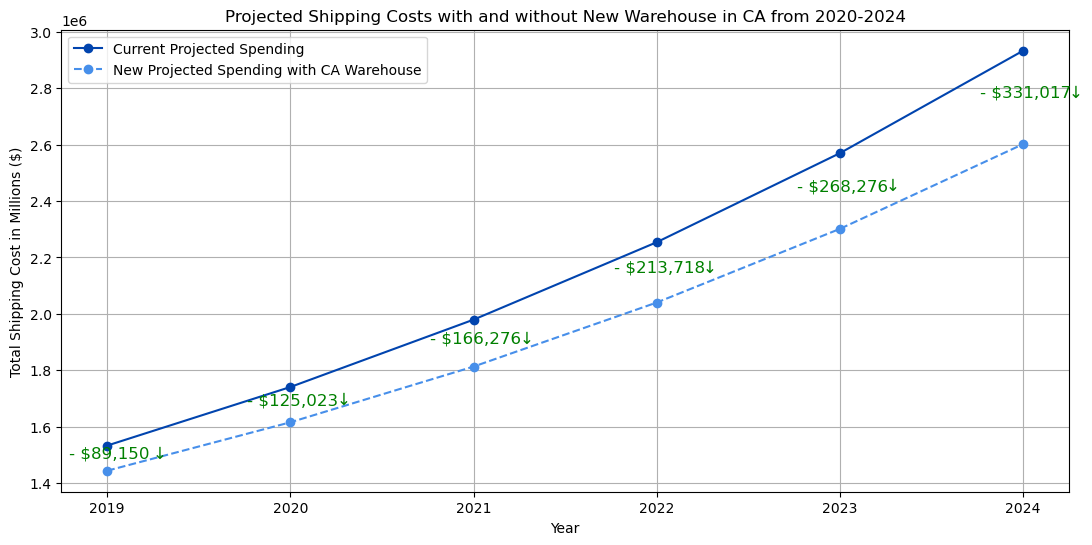

,Year,Current Total Cost ($),New Total Cost ($),Yearly Savings ($),Percent Total Savings (%),Current Shipment Costs ($),New Shipment Costs ($),Savings on Shipment Costs ($),Percent Savings on Shipping (%)
0,2019,1533482.64,1444332.24,89150.40,5.81,1383482.64,1144332.24,239150.40,17.29
1,2020,1741005.04,1615982.08,125022.96,7.18,1591005.04,1315982.08,275022.96,17.29
2,2021,1979655.79,1813379.39,166276.40,8.40,1829655.79,1513379.39,316276.40,17.29
3,2022,2254104.16,2040386.30,213717.86,9.48,2104104.16,1740386.30,363717.86,17.29
4,2023,2569719.78,2301444.24,268275.54,10.44,2419719.78,2001444.24,418275.54,17.29
5,2024,2932677.75,2601660.88,331016.88,11.29,2782677.75,2301660.88,481016.88,17.29


In [209]:
# Future current costs without the new warehouse, from above
future_costs_curr = [curr_total_spending] + future_spending

# Compute future costs with the new warehouse with a 15% YoY growth rate
future_costs_new = [CA_costs[0]] + [CA_costs[4] * ((1 + rate) ** year) + (2*annual_warehouse_cost) for year in range(1, years)]

# Calculate yearly savings over the next 5 years with a 15% YoY growth rate
yearly_savings = [future_costs_curr[i] - future_costs_new[i] for i in range(0, years)]

# Calculate shipment savings over the next 5 years with a 15% YoY growth rate
curr_projected_shipments = [annual_shipment_spend] + [annual_shipment_spend * ((1 + rate) ** year) for year in range(1, years)]
new_projected_shipments = [CA_costs[4]] + [CA_costs[4] * ((1 + rate) ** year) for year in range(1, years)]
shipment_savings = [curr_projected_shipments[i] - new_projected_shipments[i] for i in range(0, years)]

# Calculate yearly percent savings over the next 5 years with a 15% YoY growth rate
percent_total_savings = [yearly_savings[i] / future_costs_curr[i]*100 for i in range(0, years)]
percent_shipment_savings_yearly = [(shipment_savings[i] / curr_projected_shipments[i])*100 for i in range(0, years)]

# Create a DataFrame for plotting
future_costs_df = pd.DataFrame({
    'Year': [year for year in range(2019, 2025)],
    'Current Total Cost ($)': future_costs_curr,
    'New Total Cost ($)': future_costs_new,
    'Yearly Savings ($)': yearly_savings,
    'Percent Total Savings (%)': percent_total_savings,
    'Current Shipment Costs ($)': curr_projected_shipments,
    'New Shipment Costs ($)': new_projected_shipments,
    'Savings on Shipment Costs ($)': shipment_savings,
    'Percent Savings on Shipping (%)': percent_shipment_savings_yearly
    })

# Plot the future shipping costs and savings
plt.figure(figsize=(13, 6))
plt.plot(future_costs_df['Year'], future_costs_df['Current Total Cost ($)'], marker='o', linestyle='-', color='#0144ae', label='Current Projected Spending')
plt.plot(future_costs_df['Year'], future_costs_df['New Total Cost ($)'], marker='o', linestyle='--', color='#478fea', label='New Projected Spending with CA Warehouse')

# Annotate the savings
for i in range(years):
    plt.annotate(f'- ${future_costs_df["Yearly Savings ($)"][i]:,.0f}',
                 (future_costs_df['Year'][i], (future_costs_df['New Total Cost ($)'][i] + future_costs_df['Current Total Cost ($)'][i]) / 2),
                 textcoords="offset points", xytext=(1.8,0.1), ha='center', color='green', fontsize=12)
    plt.annotate('↓',
                 (future_costs_df['Year'][i], (future_costs_df['New Total Cost ($)'][i] + future_costs_df['Current Total Cost ($)'][i]) / 2),
                 textcoords="offset points", xytext=(38, 0.2), ha='center', color='green', fontsize=12)


plt.title('Projected Shipping Costs with and without New Warehouse in CA from 2020-2024')
plt.xlabel('Year')
plt.ylabel('Total Shipping Cost in Millions ($)')
plt.legend()
plt.grid(True)

# Remove the index axis
plt.xticks(future_spending_df['Year'])

plt.show()

total_savings = future_costs_df[future_costs_df['Year'] >= 2020]['Yearly Savings ($)'].sum()

# Round for better readability 
future_costs_df = future_costs_df.round(2)

future_costs_df

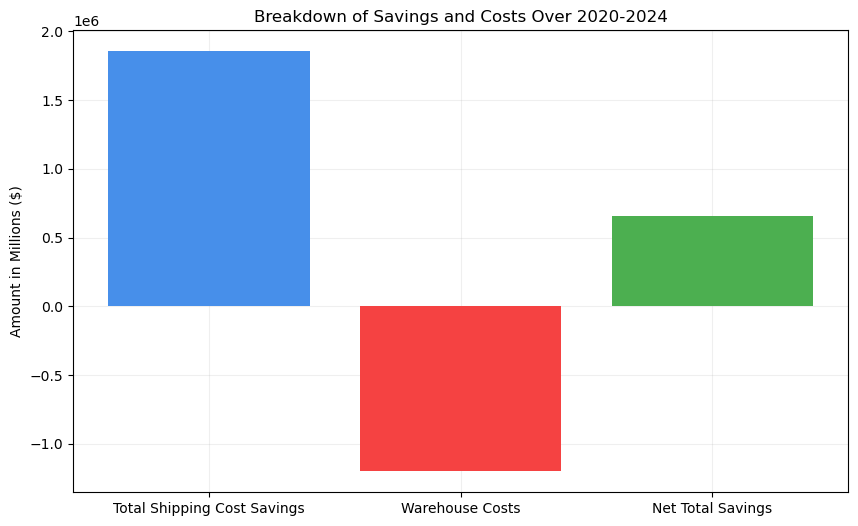

Total Savings from 2020 to 2024: $1,104,309.65
Percent Total Savings: 9.62%
Savings on Shipping Costs from 2020 to 2024: $1,854,309.64
Warehouse Costs over 5 Years:1,500,000
Net Total Savings from 2020 to 2024: $654,309.64
Percent Savings on Shipment Costs: 17.29%


In [210]:
total_warehouse_costs_2020_2024 = annual_warehouse_cost * (4) * 2
total_shipment_savings_2020_2024 = future_costs_df[future_costs_df['Year'] >= 2020]['Savings on Shipment Costs ($)'].sum()

# Net total savings
net_total_savings_2020_2024 = total_shipment_savings_2020_2024 - total_warehouse_costs_2020_2024

# Prepare data for visualization
labels = ['Total Shipping Cost Savings', 'Warehouse Costs', 'Net Total Savings']
values = [total_shipment_savings_2020_2024, -total_warehouse_costs_2020_2024, net_total_savings_2020_2024]

# Plotting
plt.figure(figsize=(10, 6))

# Adding grid lines
plt.grid(axis='x', linestyle='-', alpha=0.2)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.gca().set_axisbelow(True)

plt.bar(labels, values, color=['#478fea', '#f54242', '#4caf50'])

plt.title('Breakdown of Savings and Costs Over 2020-2024')
plt.ylabel('Amount in Millions ($)')
plt.show()

print(f"Total Savings from 2020 to 2024: ${total_savings:,.2f}")
print(f"Percent Total Savings: {(total_savings / future_costs_df[future_costs_df['Year'] >= 2020]['Current Total Cost ($)'].sum())*100:.2f}%")

print(f"Savings on Shipping Costs from 2020 to 2024: ${total_shipment_savings_2020_2024:,.2f}")
print(f"Warehouse Costs over 5 Years:{300000*5:,}")
print(f"Net Total Savings from 2020 to 2024: ${net_total_savings_2020_2024:,.2f}")
print(f"Percent Savings on Shipment Costs: {(total_shipment_savings_2020_2024 / sum([annual_shipment_spend * ((1 + rate) ** year) for year in range(1, years)]))*100:.2f}%")

## 8. Conclusion:

### In 5 years from now, another warehouse in CA **is likely to save money.** 

* A single additional warehouse would save costs and hold long-term benefits.
<br>

* The optimal location for a second warehouse is in **California.**
<br>

* By opening a second warehouse, we’d save a **grand total of $1.1M over the next 5 years.**
* That's **9.62%** in total savings. 
<br>

* We’d save **$1.85M on shipping costs *alone.***
<br>

* Warehouse costs would be **$1.5M** over the next 5 years. 
<br>
 
* Our net savings would be **$654,309.64.**
<br>

* We'd be saving **17.29%** on shipping, yearly. 